## Read Data From Kaggle

In [21]:
import json
access_token = {"username":"Your Kaggle User Name","key":"You Kaggle Token"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(access_token, file)
!pip install -q kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c competitive-data-science-predict-future-sales


item_categories.csv: Skipping, found more recently modified local copy (use --force to force download)
items.csv: Skipping, found more recently modified local copy (use --force to force download)
shops.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
test.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
sales_train.csv.gz: Skipping, found more recently modified local copy (use --force to force download)


## Import libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import random
from nltk.metrics import edit_distance
from itertools import product
mpl.rcParams['axes.grid']=True

## Load Data

In [23]:
!ls

drive		     kaggle.json	 sample_submission.csv.gz
item_categories.csv  sales_train.csv.gz  shops.csv
items.csv	     sample_data	 test.csv.gz


In [0]:
sales = pd.read_csv('sales_train.csv.gz')
test_df = pd.read_csv('test.csv.gz').set_index('ID')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

# EDA

## Utile Functions

In [0]:
def downcast_dtypes(df):
    start_size = df.memory_usage(deep = True).sum() / 1024**2
    print('Memory usage: {:.2f} MB'.format(start_size))

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    end_size = df.memory_usage(deep = True).sum() / 1024**2
    print('New Memory usage: {:.2f} MB'.format(end_size))
    return df

def display_df_info(df, name):
    print('-----------Shape of '+ name + '-------------')
    print(df.shape)
    print('-----------Missing values---------')
    print(df.isnull().sum())
    print('-----------Null values------------')
    print(df.isna().sum())
    print('-----------Data types-------------')
    print(df.dtypes)
    print('-----------Memory usage (MB)------')
    print(np.round(df.memory_usage(deep = True).sum() / 1024**2, 2))

def create_target_per_col(df, index, value, col, aggfunc = np.sum, fill = 0):
    sales_per_col = df.pivot_table(index = [index], 
                                     values = [value],
                                     columns = col, 
                                     aggfunc = aggfunc,
                                     fill_value = fill
                                    ).reset_index()
    sales_per_col.columns = sales_per_col.columns.droplevel().map(str)
    sales_per_col = sales_per_col.reset_index(drop=True).rename_axis(None, axis=1)
    sales_per_col.columns.values[0] = index
    return sales_per_col

def plot_statistic(df, title, xlbl = 'date_block_num', ylbl = 'item_cnt_day'):
    fig, axes = plt.subplots(nrows = 3 , ncols = 2,  sharex = True, figsize = (15, 8))
    for axi in axes:
        for axij in axi:
            axij.set_xticks(np.arange(34))
            axij.set_xlabel(xlbl)
            axij.set_ylabel(ylbl)
    df.sum()[1:].plot(legend=True, label = 'Sum of ' + title, ax = axes[0][0])
    df.mean()[1:].plot(legend = True, label = 'Mean of ' + title, ax = axes[1][0])
    df.median()[1:].plot(legend = True, label = 'Median of ' + title, ax = axes[2][0])
    df.max()[1:].plot(legend= True, label = 'Max of ' + title, ax = axes[0][1])
    df.min()[1:].plot(legend =True, label = 'Min of ' + title, ax = axes[1][1])
    df.std()[1:].plot(legend = True, label = 'Std of ' + title, ax = axes[2][1])
    fig.show()
    
def plot_target_per_col(df, col_name, nrows = 7, ncols = 3, ids = [], xlbl = 'date_block_num', ylbl = 'item_cnt_day'):
    row_nun = nrows
    df_sample = []
    if len(ids) == 0:
        df_sample = df.sample(nrows * ncols)
    else:
        df_sample = df[df[col_name].isin(ids)]
        row_nun = int(df_sample.shape[0] / 3 )
    fig, axes = plt.subplots(nrows = row_nun , ncols = ncols, sharex = True, figsize = (18, nrows * 2))
    x = np.arange(0, 34)
    for i, (col_id, ax) in enumerate(zip(df_sample[col_name], axes.flatten())):
        y = df_sample[df_sample[col_name] == col_id].values
        y = y[0][1:]
        ax.plot(x, y)
        if i >= nrows * ncols - 2:
            ax.set_xlabel(xlbl)
            ax.set_xticks(np.arange(34))
        ax.set_ylabel(ylbl)
        ax.set_title(col_name + ': ' + str(col_id))
    plt.show()  
    
def get_distance(x, y):
    return edit_distance(x, y)

def find_similar_name(df, col_name, distance_threshold, word_length):
    vectorized_get_distance = np.vectorize(get_distance)
    distance_arr = np.array(list(product(df[col_name], df[col_name]))).T
    distance_arr = vectorized_get_distance(distance_arr[0, :], distance_arr[1, :])
    distance_arr = distance_arr.reshape(-1, df.shape[0])
    similar_shops = []
    for i in range(distance_arr.shape[0]): 
        for j in range(distance_arr.shape[1]):
            if j < i and distance_arr[i, j] < distance_threshold and len(df.iloc[i, :][col_name]) > word_length :
                similar_shops.append((i, j))
    return similar_shops

def print_similar_pairs(df, pairs, col_id_name, col_name):
    for id1, id2 in pairs:
        name1 = df[df[col_id_name] == id1][col_name].values
        name2 =  df[df[col_id_name] == id2][col_name].values
        print(id1, ': ', name1)
        print(id2, ': ', name2)
        print('---------------------')
    if len(pairs) == 0:
        print('There is no similar entities')
              
def plot_target_counts_groupby_cols(df, cols, target):
    fig, axes = plt.subplots(nrows = 2, ncols = 2 , figsize = (18, 10))
    for i, (col, ax) in enumerate(zip(cols, axes.flatten())):
        gb = df.groupby(col).count().reset_index()
        ax.scatter(gb.index, gb[target])
        ax.set_xlim([gb.index.min() - 1, gb.index.max() + 1])
        ax.set_xlabel(col)
        ax.set_ylabel(target + 's count')
        ax.set_title(target+'s count groupby {} = {}'.format(col, gb[target].sum()))
    plt.show()
              
              
def clean_names(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
        df[col] = df[col].str.strip()
        df.loc[df[col] == '', col] = 'NULL'

## Sales

In [78]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


### Display info

In [79]:
display_df_info(sales, 'sales')
sales = downcast_dtypes(sales)

-----------Shape of sales-------------
(2935849, 6)
-----------Missing values---------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
-----------Null values------------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
-----------Data types-------------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object
-----------Memory usage (MB)------
299.58
Memory usage: 299.58 MB
New Memory usage: 226.79 MB


### Find Duplicates

In [80]:
print('Number of duplicates:', len(sales[sales.duplicated()]))

Number of duplicates: 6


In [81]:
sales = sales.drop_duplicates(keep = 'first')
print('Number of duplicates:', len(sales[sales.duplicated()]))

Number of duplicates: 0


### Plot sales columns wrt each other

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


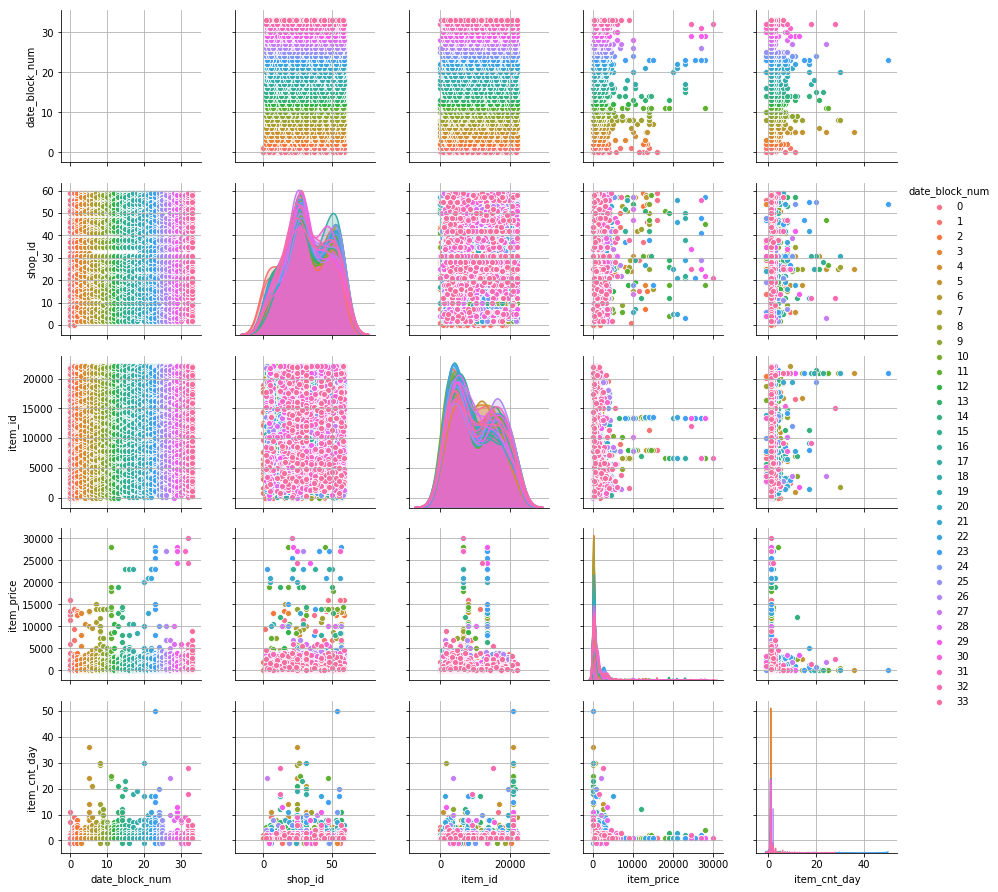

In [82]:
sales_sampled = sales.sample(n = 10000)
sns.pairplot(sales_sampled[['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']], hue = 'date_block_num', diag_kind = 'kde')
plt.show()

1. **item_cnt_day** has outliers for months 33 and 21. Possibly the amount of sales increase at end of the year
2. **item_price** has also outliers
3. Some items have huge variance in their prices at the same month
4. Not all shops are selling items during 33 months
5. It looks that there is outdated items that are not sold any more
6. There is boost of selling in months: 11, 22, 33 (the holiday season)

### Outliers

#### Item Price

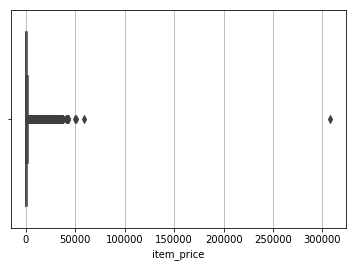

In [83]:
sns.boxplot(x = sales['item_price'])
plt.show()

In [84]:
sales = sales[sales['item_price'] < 100000]
sale_with_negative_price = sales[sales['item_price'] < 0]
sale_with_negative_price

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [0]:
sale = sales[(sales.shop_id == 32) & (sales.item_id == 2973) & (sales.date_block_num == 4) & (sales.item_price > 0)]
median = sale.item_price.median()
sales.loc[sales.item_price < 0, 'item_price'] = median

#### Items count per day

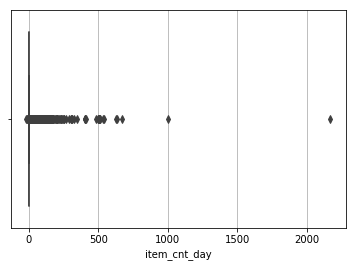

In [86]:
sns.boxplot(sales['item_cnt_day'])
plt.show()

In [87]:
sale = sales[sales['item_cnt_day'] > 500]
print('Sold item outliers', sale['item_id'].values, len(sale['item_id'].values))

Sold item outliers [ 8057 20949  9242 19437 20949  3731 11373  9249  9249  9248  9248 11373] 12


We will clip all sales amount for shops/items to [0, 20] when we constract the train set.

### Sales per Item

#### plot item_cnt_day/ log(item_cnt_day) wrt Item_id
Aggregate sales per items and compute the sum of item_cnt_day. We choose 1000 item randomly

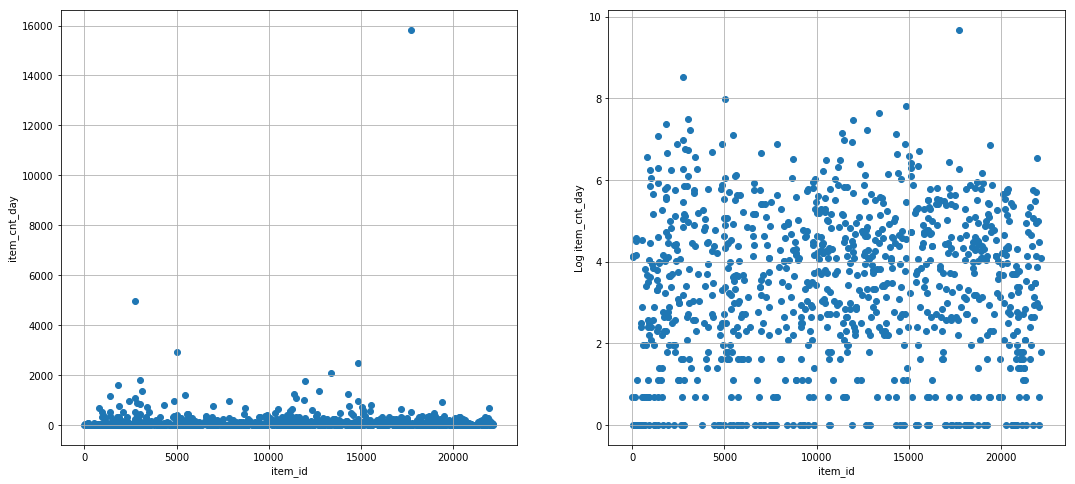

In [88]:
gb = sales.groupby('item_id').agg({'item_cnt_day' : 'sum'}).sample(1000)
item_ids = gb.index
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (18, 8))

ax1.scatter(gb.index.values, gb.item_cnt_day.values)
ax1.set_xlabel('item_id')
ax1.set_ylabel('item_cnt_day')

gb['item_cnt_day_log'] =  np.log(gb['item_cnt_day'].values)
ax2.scatter(gb.index.values, gb.item_cnt_day_log.values)
ax2.set_xlabel('item_id')
ax2.set_ylabel('Log item_cnt_day')


plt.show()

**Possible features**
1. encode item_id with mean(log(item_cnt_day)) instead of mean(item_cnt_day)

In [0]:
sales_per_item = create_target_per_col(sales, 'item_id', 'item_cnt_day', 'date_block_num')

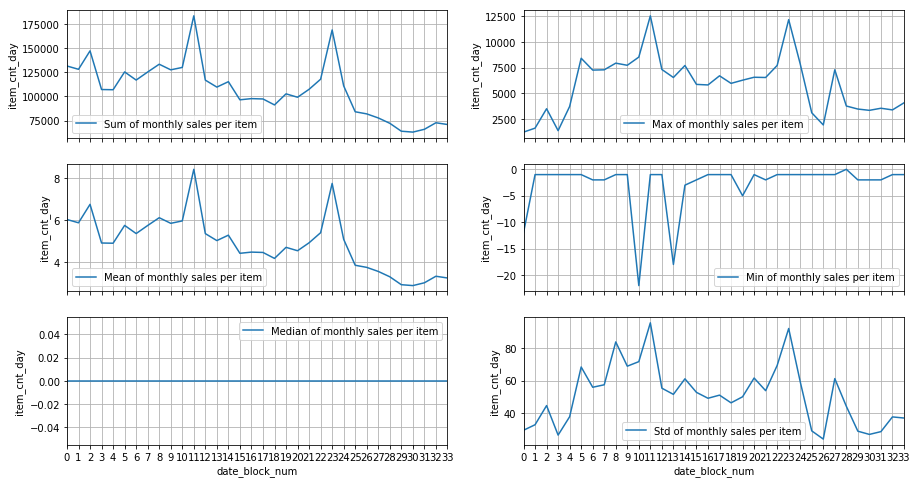

In [90]:
plot_statistic(sales_per_item, 'monthly sales per item')

Since median is zero, this means that number of items which are not sold are bigger than the items that are sold. 

The mean of sold items ranges between 1 and 10. If you generate random values in range [1, 10], you score 4.87106 which is nice as a start

**Possible Features:**
1. Pervious months sales (is it enough to lag 1 month or 2 month or 12. How many months we should go back to help the algorithm predict next month sales?)
2. Mean sales per month
3. Std of sales per month
4. Max sales per month
5. number of item's transactions (selling items, returning items)

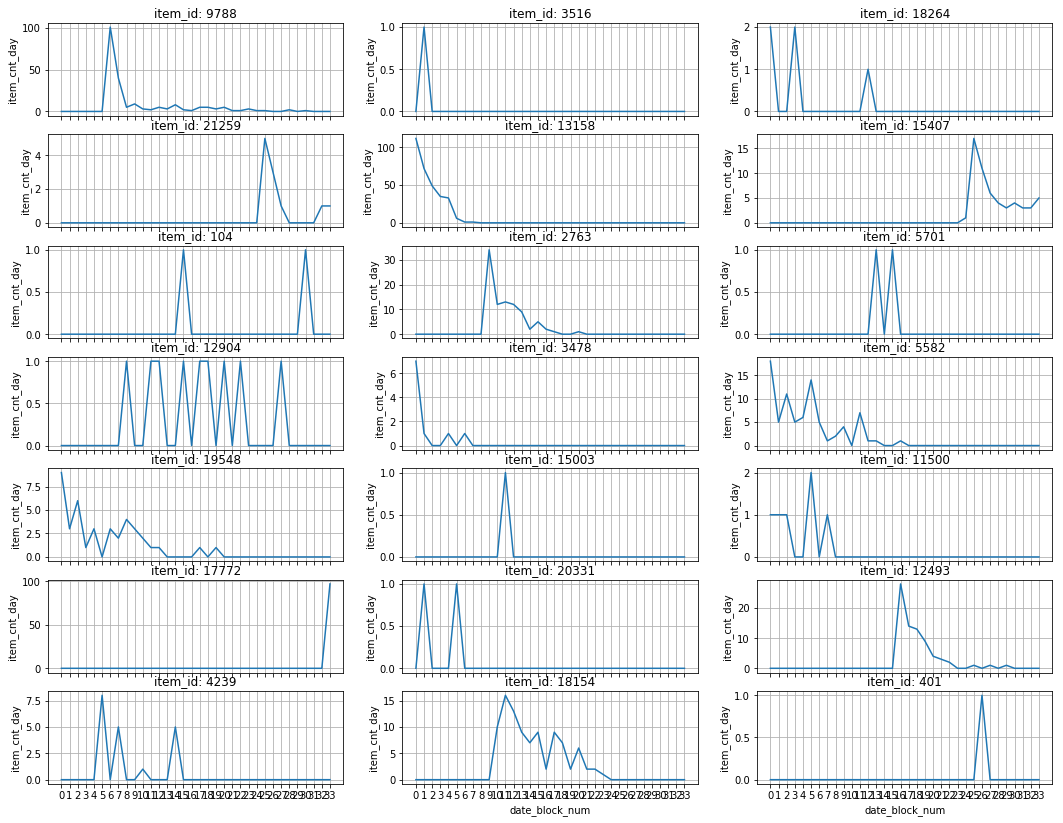

In [91]:
plot_target_per_col(sales_per_item, 'item_id')

**How many items in train set have stopped being sold since 6 months?**


---



In [92]:
outdated_items = sales_per_item[sales_per_item.loc[:,'27':].sum(axis = 1) == 0]
print('Outdated items in train set: ',  len(outdated_items), 'out of', len(sales_per_item))
print(np.round(100 * len(outdated_items) / len(sales_per_item), 2), '% of the items in train set stopped being sold since the last 6 months')

Outdated items in train set:  12390 out of 21806
56.82 % of the items in train set stopped being sold since the last 6 months


**Possible Features**
1. when item start to be sold
2. when item stopped from being sold (item is not sold since 4 or 6 months)
3. item selling duration
4. item pervious sales


### Sales per shop

In [0]:
sales_per_shop = create_target_per_col(sales, 'shop_id', 'item_cnt_day', 'date_block_num')

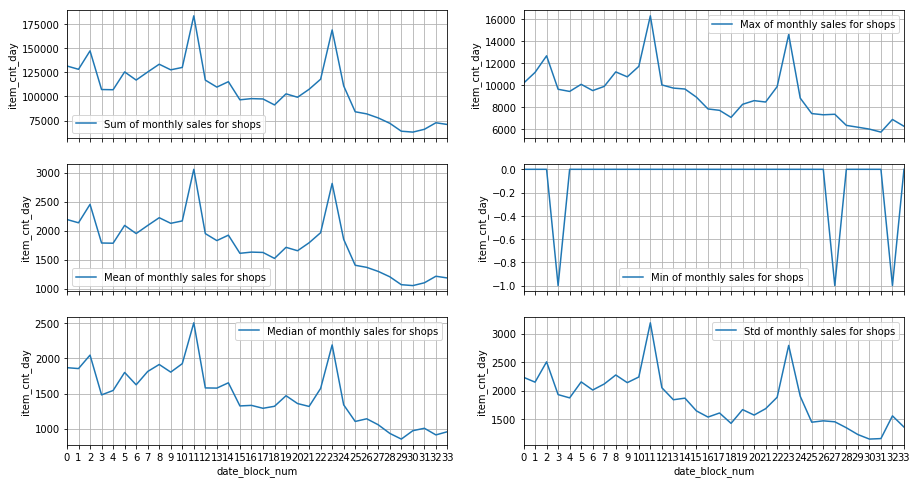

In [94]:
plot_statistic(sales_per_shop, 'monthly sales for shops')

**Possible Features:**

1. Pervious months sales
2. Mean & Median sales per month
3. Std of sales per month
4. Max sales per month
5. Seasonality and trend features for total amount of sales

#### Shops that started selling late

In [95]:
for month in range(6, 34):
  shop_ids = sales_per_shop['shop_id'][sales_per_shop.loc[:,'0':str(month)].sum(axis=1) == 0].unique()
  print('From month: 0 until: ', month, ', Shops that have made No sales are: ', shop_ids)

From month: 0 until:  6 , Shops that have made No sales are:  [ 9 11 20 33 34 36 39 40 48 49]
From month: 0 until:  7 , Shops that have made No sales are:  [ 9 11 20 33 34 36 39 40 48 49]
From month: 0 until:  8 , Shops that have made No sales are:  [ 9 11 20 33 34 36 39 40 48 49]
From month: 0 until:  9 , Shops that have made No sales are:  [11 20 33 34 36 39 40 48 49]
From month: 0 until:  10 , Shops that have made No sales are:  [11 20 33 34 36 39 40 48 49]
From month: 0 until:  11 , Shops that have made No sales are:  [11 20 33 34 36 39 40 48]
From month: 0 until:  12 , Shops that have made No sales are:  [11 20 33 34 36 39 40 48]
From month: 0 until:  13 , Shops that have made No sales are:  [11 20 33 34 36 39 40 48]
From month: 0 until:  14 , Shops that have made No sales are:  [11 20 33 34 36 48]
From month: 0 until:  15 , Shops that have made No sales are:  [11 20 33 34 36]
From month: 0 until:  16 , Shops that have made No sales are:  [11 20 33 34 36]
From month: 0 until:  17 

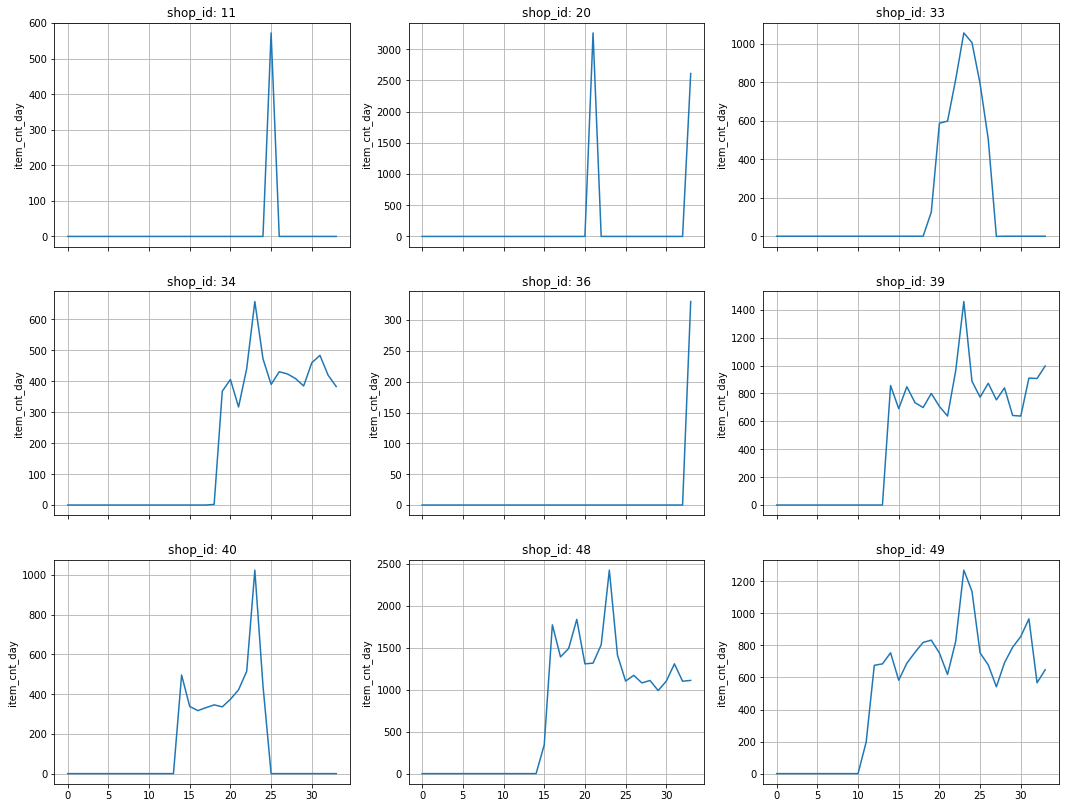

In [96]:
plot_target_per_col(sales_per_shop, 'shop_id', ids = [49, 48, 40, 39, 34, 33, 20, 11, 36])

#### Shops that stopped selling early

In [97]:
for month in range(6, 28):
  shop_ids = sales_per_shop['shop_id'][sales_per_shop.loc[:, str(month):].sum(axis=1)==0].unique()
  print('From month: ', month, 'Until 33, Shops that stopped selling: ', shop_ids)

From month:  6 Until 33, Shops that stopped selling:  [ 0  1  8 23]
From month:  7 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  8 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  9 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  10 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  11 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  12 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  13 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  14 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  15 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  16 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  17 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  18 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]
From month:  19 Until 33, Shops that stopped selling:  [ 0  1  8 23 32]

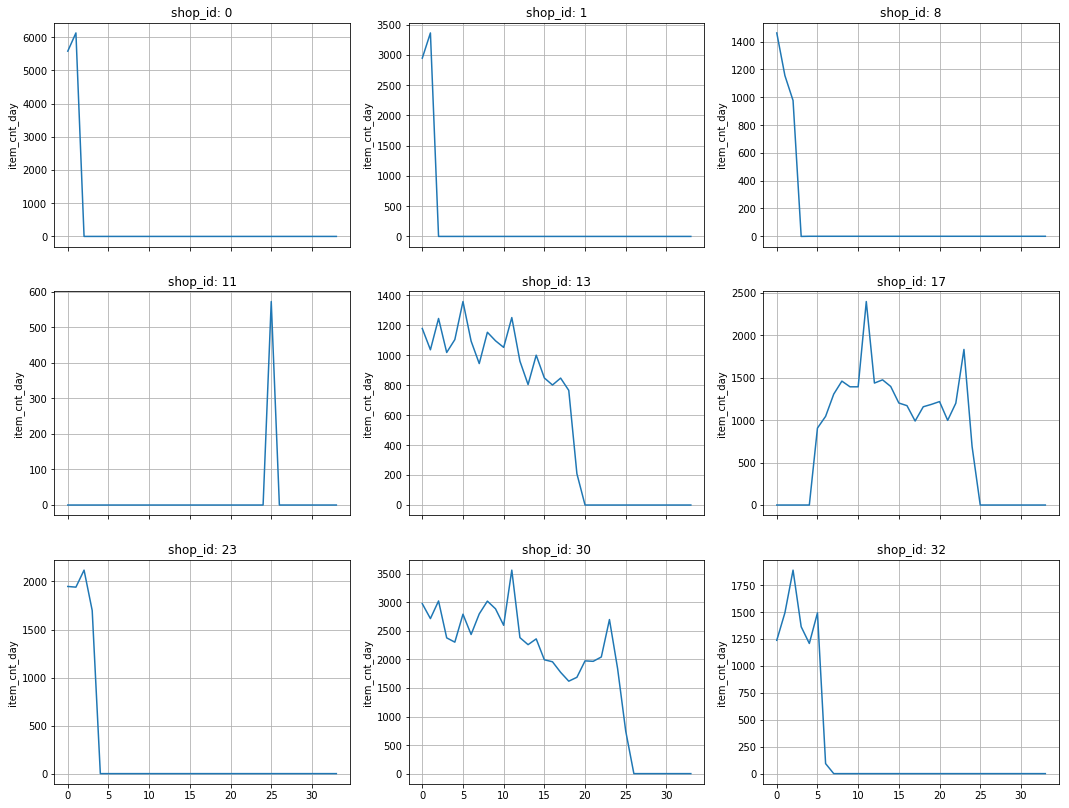

In [98]:
plot_target_per_col(sales_per_shop, 'shop_id', ids = [ 0, 1, 8, 11, 13, 17, 23, 30, 32, 40, 43])

#### Statistics for sales for shop: 7

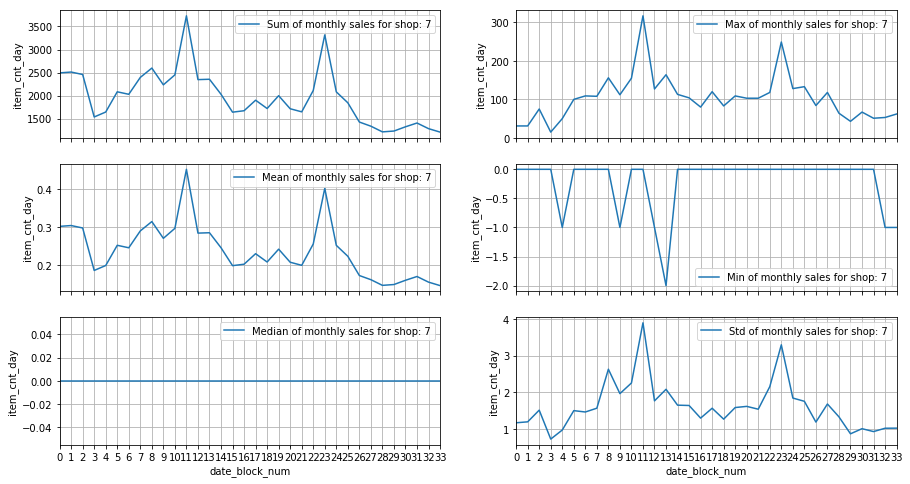

In [99]:
shop_id = 7
sales_shops_7 = sales[sales['shop_id'] == shop_id]
sales_shops_7 = create_target_per_col(sales_shops_7, 'item_id', 'item_cnt_day', 'date_block_num')
plot_statistic(sales_shops_7, 'monthly sales for shop: ' + str(shop_id))

Interesting thing is that mean of count of sold items per shop is in a range [0.1, 0.5], the maximum ranges between 20 to 350.
This mean that those shops stores alot of items that they don't sell.

Shops that opened after 6 months and shops that stopped selling since the last 6 months have low amount of selling.

**Possible Features**

1. shop start month of selling/shop end month of selling
2. shop selling duration
3. has the shop made sales during the last 6 months (is_shop_outdated)
4. shop's revenue
5. number of shop's transactions (selling items, returning items)

### Price

Price change per item, shop, and time. Let us visualize the previous relation and find how price history affect the amount of sold items.


#### Price per Items / months

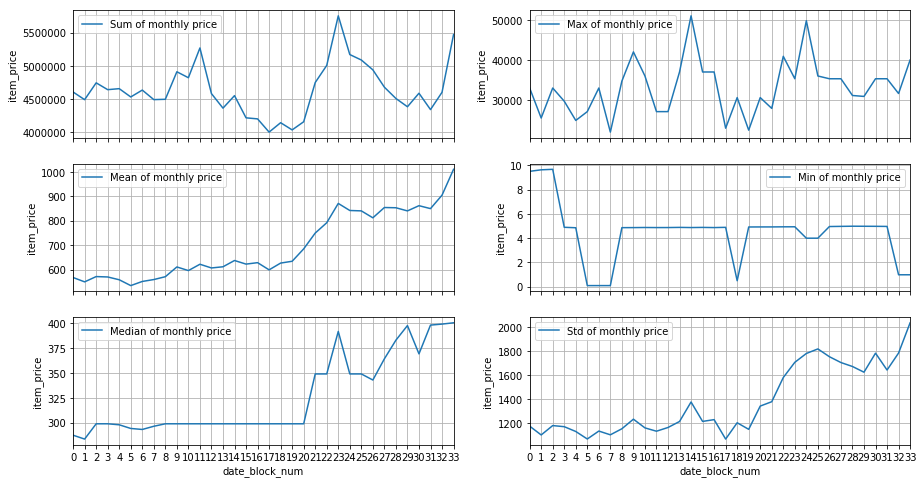

In [100]:
item_prices = create_target_per_col(sales, 'item_id', 'item_price', 'date_block_num', aggfunc = np.mean, fill = np.nan)
plot_statistic(item_prices, 'monthly price', 'date_block_num', 'item_price')

It is clear that the mean of prices is increasing and the sales amount is decreasing.

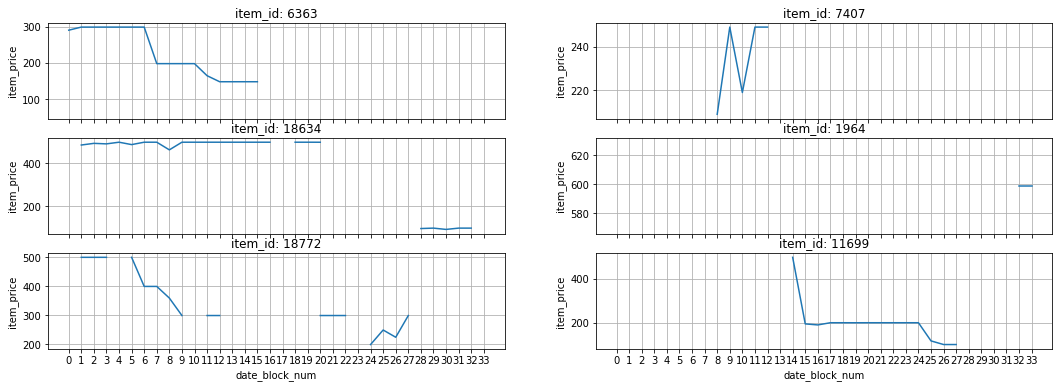

In [101]:
plot_target_per_col(item_prices, 'item_id', nrows = 3, ncols = 2, ids = [], xlbl = 'date_block_num', ylbl = 'item_price')

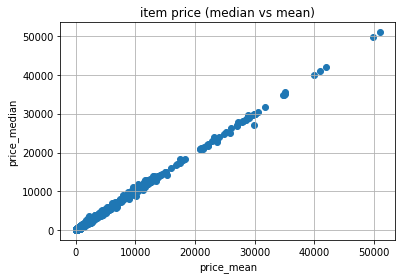

In [102]:
item_prices['price_mean'] = item_prices.loc[:, '0':].mean(axis = 1)
item_prices['price_median'] = item_prices.loc[:, '0':].median(axis = 1)
plt.scatter(item_prices.price_mean, item_prices.price_median)
plt.xlabel('price_mean')
plt.ylabel('price_median')
plt.title('item price (median vs mean)')
plt.show()

#### Price per item/shop/month

In [0]:
cols = ['item_id', 'shop_id', 'date_block_num']
gb = sales.groupby(by = cols ).agg({'item_cnt_day': 'sum', 'item_price': ['min','mean', 'median', 'max']})
gb.columns = gb.columns.map('_'.join).str.strip('_')
gb = gb.reset_index()


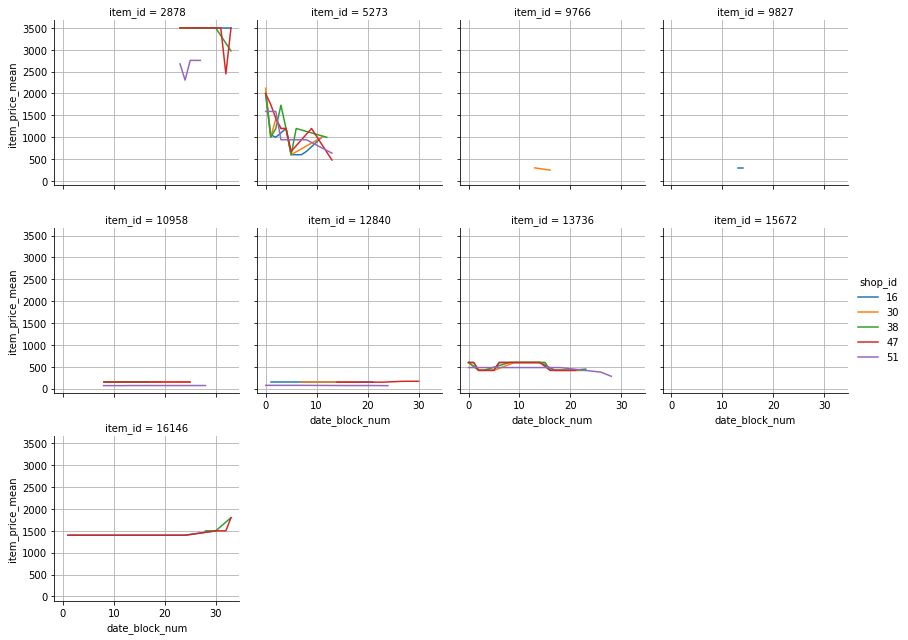

In [104]:
item_ids = [5273, 10958, 9766, 13736, 16551, 16146, 12840]
item_ids = np.concatenate((item_ids, np.random.choice(sales['item_id'].unique(), 3)), axis=0)
df = gb[gb['item_id'].isin(item_ids)]
shop_ids = []
if len(df['shop_id'].unique()) > 5:
  shop_ids = np.random.choice(df['shop_id'].unique(), 5)
df = df[df['shop_id'].isin(shop_ids)]
g = sns.FacetGrid(df, col="item_id", hue = 'shop_id', col_wrap = 4)
g = g.map(plt.plot, "date_block_num", "item_price_mean").add_legend()
plt.show()


**Amount of selling for the same items and shops above.**


---



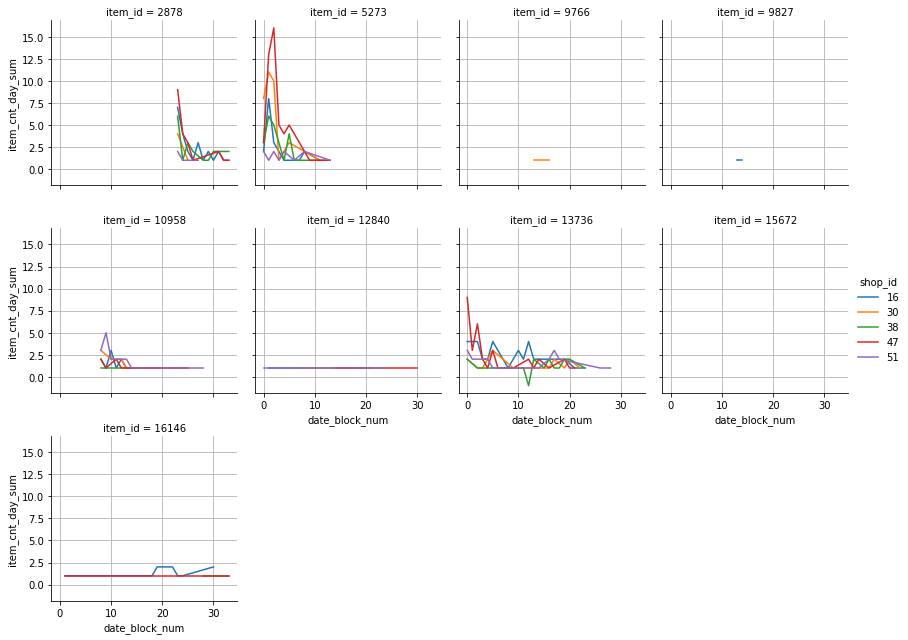

In [105]:
df = gb[gb['item_id'].isin(item_ids)]
df = df[df['shop_id'].isin(shop_ids)]
g = sns.FacetGrid(df, col="item_id", hue = 'shop_id', col_wrap = 4)
g = g.map(plt.plot, "date_block_num", "item_cnt_day_sum").add_legend()
plt.show()


#### Price / item_cnt_day

In [0]:
df = sales.loc[(sales.loc[:, 'item_price'] > 0) & (sales.loc[:, 'item_price'] < 100000)]
df = df.reset_index()
item_prices = df.loc[:, 'item_price'].values
item_prices = np.unique(item_prices)
item_prices = np.sort(item_prices)
bins = np.min(item_prices)
bins = np.random.choice(item_prices, 98)
bins = np.sort(bins)
bins = np.append(bins, np.max(item_prices))
lbls = bins[1:]
df.loc[:, 'item_price_binned'] = pd.cut(df.loc[:, 'item_price'], bins = bins, labels = lbls, right = True, duplicates = 'drop')
gbbinned = df.groupby('item_price_binned').agg({'item_cnt_day' : 'sum'})
gb = df.groupby('item_price').agg({'item_cnt_day' : 'sum'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


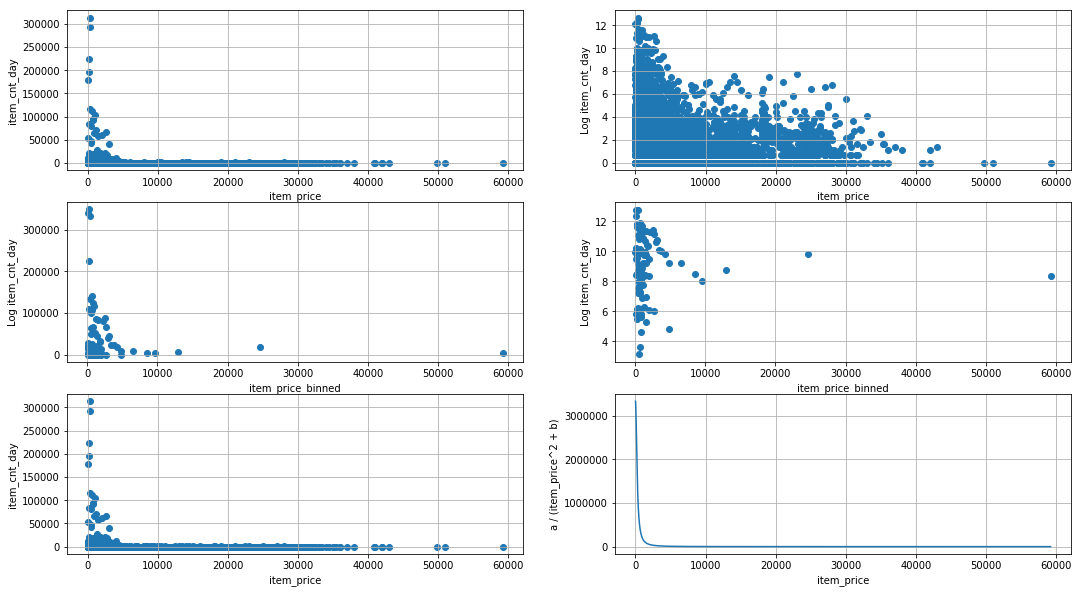

In [107]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2, sharex = False, figsize = (18, 10))

ax1.scatter(gb.index.values, gb.item_cnt_day.values)
ax1.set_xlabel('item_price')
ax1.set_ylabel('item_cnt_day')

gb['item_cnt_day_log'] =  np.log(gb['item_cnt_day'].values)
ax2.scatter(gb.index.values, gb.item_cnt_day_log.values)
ax2.set_xlabel('item_price')
ax2.set_ylabel('Log item_cnt_day')

ax3.scatter(np.array(gbbinned.index.values), gbbinned.item_cnt_day.values)
ax3.set_xlabel('item_price_binned')
ax3.set_ylabel('Log item_cnt_day')

gbbinned['item_cnt_day_log'] =  np.log(gbbinned['item_cnt_day'].values)
ax4.scatter(np.array(gbbinned.index.values), gbbinned.item_cnt_day_log.values)
ax4.set_xlabel('item_price_binned')
ax4.set_ylabel('Log item_cnt_day')

ax5.scatter(gb.index.values, gb.item_cnt_day.values)
ax5.set_xlabel('item_price')
ax5.set_ylabel('item_cnt_day')

cnt_day =  2 * np.power(10, 11) / (np.power(gb.index.values, 2) + 60000)
ax6.plot(gb.index.values, cnt_day)
ax6.set_xlabel('item_price')
ax6.set_ylabel('a / (item_price^2 + b)')

plt.show()

In [108]:
corr1 = np.abs(np.corrcoef(np.array(gbbinned.index.values), gbbinned.item_cnt_day_log.values)[0][1])
corr2 = np.abs(np.corrcoef(np.array(gbbinned.index.values), gbbinned.item_cnt_day.values)[0, 1])
print('correlation between pinned_price, Log(item_cnt_day): ', corr1)
print('correlation between pinned_price, item_cnt_day: ', corr2)


correlation between pinned_price, Log(item_cnt_day):  0.005763015922745861
correlation between pinned_price, item_cnt_day:  0.09272441340976029


In general, when Price goes down the item_cnt_day goes up.

Last row in the figure shows that the relation between item_price and item_cnt_day could be:

- item_cnt_day = a / (item_price^2 + b)

Providing this relation as a transformation of the price feature may help the machine to learn faster how to map the price of items to their selling amount. In other words the machine need to learn the identity function or just ***a*** and ***b*** instead of this f(x) = a / (x^2 + b)


If we binned the price values and then aggregate the mount of sold items wrt price intervals, We see that we maintained the same ditrbutions and reduced the complexity. In other words, it is easier for the machine to map 100 price intervals to the target instead of mapping infinite number of values to the target.

Taking the log of aggregated sales, amplifies the effect of price variance 
on the target variance.

The question is by iterducing the log relation, are we increasing the information and helping the model to learn faster or we just add noise.
Is changing the price to be categorical is going to help, taking into account that we deal with regression problem. Regression models work best with continues variables.

**Possible Features**
1. item_price
2. item_price history, trend and seasonality analyis(lag features)
3. revenue per shop as an interaction between (item_cnt_day * item_price)
4. revenue history for shops
5. discount and discount duration for items per shops
6. binning Price(not sure)
7. price encoded with the log of total item_cnt_day (not sure)
8. transformed_price = a / (item_price^2 + b) (not sure)

More features help the ML algo to find hidden structures in the data. But we need to be carefull or we will add unneeded complixity for the model to deal with. 

### Date

#### Convert sales.date form string to datetime

In [0]:
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [110]:
print('First sale took place: ', sales.date.min())
print('Last sale took place: ', sales.date.max())

First sale took place:  2013-01-01 00:00:00
Last sale took place:  2015-10-31 00:00:00


**Possible Date features:** 

(stolen from kyakovlev)
1. Weekends and holidays sales (to correct monthly sales)
2. Number of days in the month (to correct monthly sales)
3. Month number (for seasonal items)

## Test set

In [111]:
test_df.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
shop_id,214200.0,31.642857,17.561933,2.0,16.0,34.5,47.0,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.5,11203.0,16071.5,22167.0


### Display info

In [112]:
display_df_info(test_df, 'Test set')
test_df = downcast_dtypes(test_df)

-----------Shape of Test set-------------
(214200, 2)
-----------Missing values---------
shop_id    0
item_id    0
dtype: int64
-----------Null values------------
shop_id    0
item_id    0
dtype: int64
-----------Data types-------------
shop_id    int64
item_id    int64
dtype: object
-----------Memory usage (MB)------
4.9
Memory usage: 4.90 MB
New Memory usage: 2.45 MB


### Plot test columns wrt each other

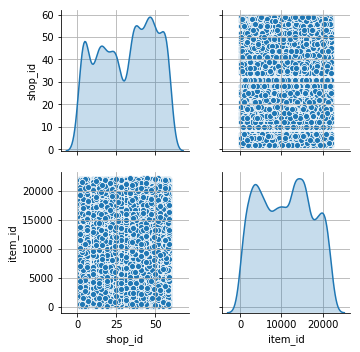

In [113]:
test_sampled = test_df.sample(n = 10000)
sns.pairplot(test_sampled, diag_kind = 'kde')
plt.show()

### Test set distribution

In [114]:
test_df.groupby(by = 'shop_id')['item_id'].nunique()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
Name: item_id, dtype: int64

In [115]:
items_test = set(test_df.item_id)
items_sales = set(sales.item_id)
item_in_test_and_sales = items_test.intersection(items_sales)
item_in_test_not_sales = set(test_df.item_id) - items_sales.intersection(items_test)
print('There is sales history for:', len(item_in_test_and_sales) , ' items in test set')
print('There is No sales history for:', len(item_in_test_not_sales), ' items in test set')

There is sales history for: 4737  items in test set
There is No sales history for: 363  items in test set


How many Items in test set have stopped from being sold since the last 6 month?

In [116]:
unique_outdated_items = set(outdated_items.item_id)
test_outdated_items = test_df[test_df['item_id'].isin(unique_outdated_items)]
u_test_outdated_items = set(test_outdated_items.item_id)
print('Outdated items in test set:', len(u_test_outdated_items), 'out of', test_df.item_id.nunique())
print(np.round(100 * len(u_test_outdated_items) / test_df.item_id.nunique(), 2), 
      '% of the items in test set stopped being sold since the last 6 months')

Outdated items in test set: 164 out of 5100
3.22 % of the items in test set stopped being sold since the last 6 months


How many Shops in test set stopped selling since the last 6 month?

In [117]:
disactive_shops = [ 0,  1,  8, 11, 13, 17, 23, 30, 32, 40, 43]
test_outdated_shops = test_df.loc[test_df['shop_id'].isin(disactive_shops)]['shop_id'].nunique()
print('Outdated shops in test set:',test_outdated_shops, 'out of', test_df.shop_id.nunique())

Outdated shops in test set: 0 out of 42


In [118]:
shops_test = set(test_df.shop_id)
shops_sales = set(sales.shop_id)
shops_in_test_and_sales = shops_test.intersection(shops_sales)
shops_in_test_not_sales = set(test_df.shop_id) - shops_test.intersection(shops_sales)
print('There is sales history for:', len(shops_in_test_and_sales), ' shops in test set')
print('There is No sales history for:', len(shops_in_test_not_sales), ' shops in test set')

There is sales history for: 42  shops in test set
There is No sales history for: 0  shops in test set


This is challenging. We need to pridect futures sales for 363 items with no knowledge of their historical sales transactions.

If we generate random predictions and used the insights that we found:
- mean of the target per item is in range: [1, 10]
- **12391** items in train set and **164** items in test set are not sold anymore (set predictoin to 0)

You get a score: 2.96710, no machine learning involved, just random predictions.

In [0]:
test = test_df.reset_index()
pred = np.random.normal(3, 0.5, test_df.shape[0])
test.loc[:, 'pred'] = pred

test.loc[test_df['item_id'].isin(list(u_test_outdated_items)), 'pred'] = 0

sub = pd.DataFrame(columns = ['ID'])
sub.loc[:,'ID'] = test.loc[:,'ID']
sub1 = sub.merge(test[['ID',	'pred']], on = 'ID', how = 'inner')
sub1.rename(columns = {'pred': 'item_cnt_month'}, inplace = True)
#sub1.to_csv(data_path + '/rand1.csv', index = False)

In [119]:
item_shop_test = set(test_df.item_id.astype(str) + '_' +test_df.shop_id.astype(str))
item_shop_sales = set(sales.item_id.astype(str) + '_' + sales.shop_id.astype(str))
pairs_with_history = len(item_shop_test.intersection(item_shop_sales) )
pairs_with_no_history = len(shops_in_test_and_sales) * len(item_in_test_not_sales)
just_item_with_history = test_df.shape[0] - (pairs_with_history + pairs_with_no_history)
print('There is sales history for:', pairs_with_history , ' shop/item pairs in test set')
print('There is No sales history for:',  pairs_with_no_history, ' shop/item in test set')
print('There is sales history for:',  just_item_with_history, ' items ONLY from shop/item pairs in test set')

There is sales history for: 111404  shop/item pairs in test set
There is No sales history for: 15246  shop/item in test set
There is sales history for: 87550  items ONLY from shop/item pairs in test set


In [72]:
print('predict probability for item/shop pair: ', 100 * (pairs_with_history) / test_df.shape[0], '%')

print('predict probability for item/shop pairs with info about partial items is: '
      , 100 * (pairs_with_history + just_item_with_history) / test_df.shape[0], '%')

predict probability for item/shop pair:  52.0093370681606 %
predict probability for item/shop pairs with info about partial items is:  92.88235294117646 %


1. A super Model that uses the historical info for item/shop pairs Optimaly, should predict correctly with probability:  52.00 %
2. A super Model that uses the historical info for item/shop pairs with info about partial items Optimaly, should predict correctly with probability:  92.88 %

The above numbers are correct if there is in reality a perfect ML model able to find a function that maps between ***a(t)*** and ***a(t - 1)***, where ***a*** is the ***item_cnt_month*** for pair ***item/shop*** and ***t*** is time (month). Also this model is able to map attribute features of items to ***item_cnt_month*** .

Let us model the problem as finding a series ***A*** where ***n = A(n-1)***. This is not enough we still need to make the model look to item attributes and then figure out the target from those attributes (this is hard since we just know the ids, prices and item categories, shop names).

**Some notes:**
1. A model that has been trianed on the historical sales data and knows how to map ***a(t)*** and ***a(t - 1)*** will predict correctly with a chance of 52%. 
2. To increase the prediction quality we should tell the model to consider other features that describe the items and the shops and learn how to map those features to the amount of selling.

**Modeling Ideas:**

Look to the problem from tow different prespective: 
1. Build models that learn to map attribute data about items/shops to the selling amount(Decesion Trees, Catboost,  Gradient Boosting Machine, ...)
2.Build models that learn how to map time series data to the current selling amount(RNN, LinearRegression, ...)
3. Combain the output of those models to create final predictions (NN, LinearRegression, Gradient Boosting Machine, Decesion Trees, ...)

We know that the total amount of sold items per shop should be in range [0, 20]. Also selling amount is an integer, this means we have a classification problem with 20 classes.
But the scoring metric for the contest is RMSE, a default metric for scoring regression models.




## Items

In [120]:
items.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_name,22170,22170,9 1/2 НЕДЕЛЬ (Регион),1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,22170,NaN,NaN,NaN,11084.5,6400.07,0,5542.25,11084.5,16626.8,22169
item_category_id,22170,NaN,NaN,NaN,46.2908,15.9415,0,37,40,58,83


### Display info

In [121]:
display_df_info(items, 'Items')
items = downcast_dtypes(items)

-----------Shape of Items-------------
(22170, 3)
-----------Missing values---------
item_name           0
item_id             0
item_category_id    0
dtype: int64
-----------Null values------------
item_name           0
item_id             0
item_category_id    0
dtype: int64
-----------Data types-------------
item_name           object
item_id              int64
item_category_id     int64
dtype: object
-----------Memory usage (MB)------
3.66
Memory usage: 3.66 MB
New Memory usage: 3.41 MB


### Plot columns wrt each other

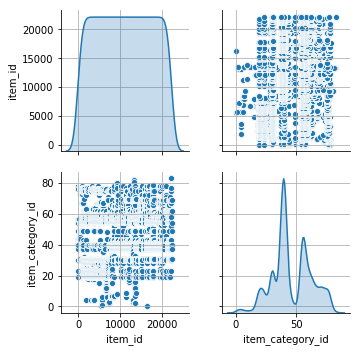

In [122]:
sns.pairplot(items, diag_kind = 'kde')
plt.show()

### Item_name preprocessing
Stolen from https://www.kaggle.com/kyakovlev

**item_name** contains the name, type, and subtype in following format:

- c_item_name [item_type] (item_subtype).

In [123]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


#### Extract c_item_name /item_type /item_subtype

In [137]:
nitems = items.copy()

nitems['c_item_name'], nitems['item_type'] = nitems['item_name'].str.split('[', 1).str
nitems['c_item_name'], nitems['item_subtype'] = nitems['c_item_name'].str.split('(', 1).str

clean_names(nitems, ['item_name', 'c_item_name', 'item_type', 'item_subtype'])
print('Number of items:', nitems['item_id'].nunique())
print('Number of item_name:', nitems['item_name'].nunique())
print('Number of c_item_name:', nitems['c_item_name'].nunique())
print('Number of item_type:', nitems['item_type'].nunique())
print('Number of item_subtype:', nitems['item_subtype'].nunique())

Number of items: 22170
Number of item_name: 22075
Number of c_item_name: 18121
Number of item_type: 169
Number of item_subtype: 1535


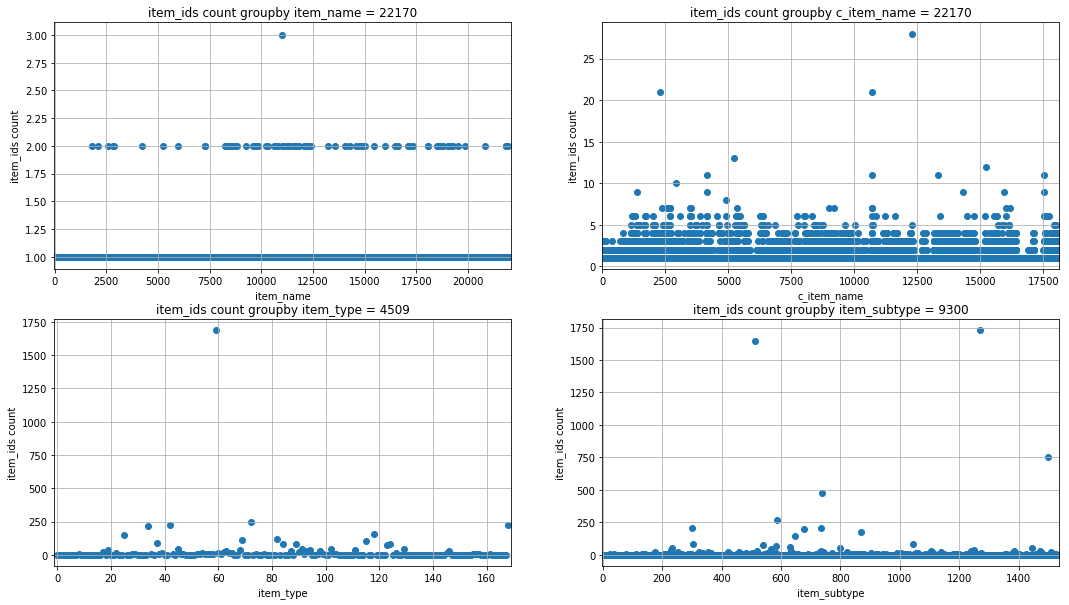

In [138]:
plot_target_counts_groupby_cols(nitems, ['item_name', 'c_item_name', 'item_type', 'item_subtype'], 'item_id')

**This figure tell us that:**
- 22170 can be described by 22170 names
- 22170 can be described by 18121 c_names
- 4509 can be described by 169 item_types
- 9300 can be described by 1535 item_sub_types

In [0]:
#nitems.groupby(['c_item_name']).count()
#nitems.groupby(['item_type1']).count()
#nitems.groupby(['item_type2']).count()
#nitems.groupby(['item_subtype']).count()

#### Items with the same: c_name / item_type / item_subtype / item_category_id:

In [142]:
cols = ['item_category_id', 'item_name', 'c_item_name', 'item_type', 'item_subtype']
duplicated_items = nitems[nitems[cols].duplicated(keep = 'first')].item_id
print('Number of duplicated items: ', len(duplicated_items))
trans_duplicated_items = sales[sales['item_id'].isin(duplicated_items)]
print('Number of transactions on the duplicated items: ', len(trans_duplicated_items))
print('Number of outdated duplicated items', len(outdated_items[outdated_items['item_id'].isin(duplicated_items)].item_id.unique()))

test_duplicated_items = test_df[test_df['item_id'].isin(duplicated_items)]
print('Number of duplicated items in test set: ', test_duplicated_items.item_id.nunique())
print('Number of outdated duplicated items in test set:', len(test_outdated_items[test_outdated_items['item_id'].isin(duplicated_items)].item_id.unique()))

Number of duplicated items:  89
Number of transactions on the duplicated items:  10127
Number of outdated duplicated items 55
Number of duplicated items in test set:  9
Number of outdated duplicated items in test set: 1


After deleting the stop characters like (\*, /) and lowercasing the item_name, we found that 89 items are duplicated.

It could be that those items are not duplicated and those weird characters are added to the names on purpose to distinguish them from other items.

Deleting data is not good and it is the last thing we should do, here is a solution:
- duplicate the predictions for those items(prediction is correct for the orginal items you win alot. prediction is wrong you lose alot)
- on average we have 300 transaction per active item in the train set. So adding 10127 / 89 = 113 transactions to the 89 orignal items out of 21800 is not going to change the predictions that much.
- keep them and no need to bother, 55 of them are outdated anyway

**Possible Features**
1. find the most frequent words form the strings that we extracted form the item name
2. say we have 50 term. Those terms will be a categorical feature that can be used to map items to its levels
3. Mapping can be done by choosing the category level that occurs the most in the item name

## Item_categories

In [143]:
item_categories.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_category_name,84,84,Книги - Бизнес литература,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_category_id,84,NaN,NaN,NaN,41.5,24.3926,0,20.75,41.5,62.25,83


### Dispaly info

In [144]:
display_df_info(item_categories, 'Item Categories')
item_categories = downcast_dtypes(item_categories)

-----------Shape of Item Categories-------------
(84, 2)
-----------Missing values---------
item_category_name    0
item_category_id      0
dtype: int64
-----------Null values------------
item_category_name    0
item_category_id      0
dtype: int64
-----------Data types-------------
item_category_name    object
item_category_id       int16
dtype: object
-----------Memory usage (MB)------
0.01
Memory usage: 0.01 MB
New Memory usage: 0.01 MB


### Plot columns wrt each other

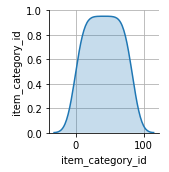

In [145]:
sns.pairplot(item_categories, diag_kind = 'kde')
plt.show()

### Category name preprocessing
Stolen from https://www.kaggle.com/kyakovlev

Category name contains the following info:

- section/category_name/subcategory_name1/subcategory_name2

#### Translate Category names

In [0]:
strings = """PC - Headsets / Headphones
Accessories - PS2
Accessories - PS3
Accessories - PS4
Accessories - PSP
Accessories - PSVita
Accessories - XBOX 360
Accessories - XBOX ONE
Tickets (Digit)
Delivery of goods
Game Consoles - PS2
Game Consoles - PS3
Game Consoles - PS4
Game Consoles - PSP
Game Consoles - PSVita
Game Consoles - XBOX 360
Game Consoles - XBOX ONE
Game consoles - Other
Games - PS2
Games - PS3
Games - PS4
Games - PSP
Games - PSVita
Games - XBOX 360
Games - XBOX ONE
Games - Accessories for games
Android Games - Number
MAC Games - Digit
PC Games - Additional Editions
PC Games - Collector's Editions
PC Games - Standard Editions
PC Games - Digit
Payment cards (Cinema, Music, Games)
Payment Cards - Live!
Payment Cards - Live! (Numeral)
Payment Cards - PSN
Payment Cards - Windows (Digit)
Cinema - Blu-ray
Cinema - Blu-ray 3D
Cinema - Blu-ray 4K
Cinema - DVD
Cinema - Collectible
Books - Artbooks, Encyclopedias
Books - Audiobooks
Books - Audiobooks (Digit)
Books - Audiobooks 1C
Books - Business Literature
Books - Comics, Manga
Books - Computer Literature
Books - Methodological materials 1C
Books - Postcards
Books - Educational literature
Books - Guides
Books - Fiction
Books - Number
Music - Local Production CD
Music - Brand-Made CD
Music - MP3
Music - Vinyl
Music - Music Video
Music - Gift Editions
Gifts - Attributes
Gifts - Gadgets, Robots, Sports
Gifts - Soft Toys
Gifts - Board Games
Gifts - Board games (compact)
Gifts - Postcards, stickers
Gifts - Development
Gifts - Certificates, services
Gifts - Souvenirs
Gifts - Souvenirs (in bulk)
Gifts - Bags, Albums, Mousepads
Gifts - Figures
Programs - 1C: Enterprise 8
Programs - MAC (Digit)
Programs - For home and office
Programs - For home and office (Digit)
Programs - Educational
Programs - Educational (Digital)
Office
Service - Tickets
Net carriers (spire)
Blank media (piece)
Batteries"""
categories = pd.DataFrame(columns = ['item_category_id', 'item_category_name'])
categories.item_category_id = item_categories.item_category_id
categories.item_category_name = strings.split('\n')
categories.item_category_name = categories.item_category_name.str.lower()
categories.item_category_name = categories.item_category_name.str.strip()

#### Extract info form category names

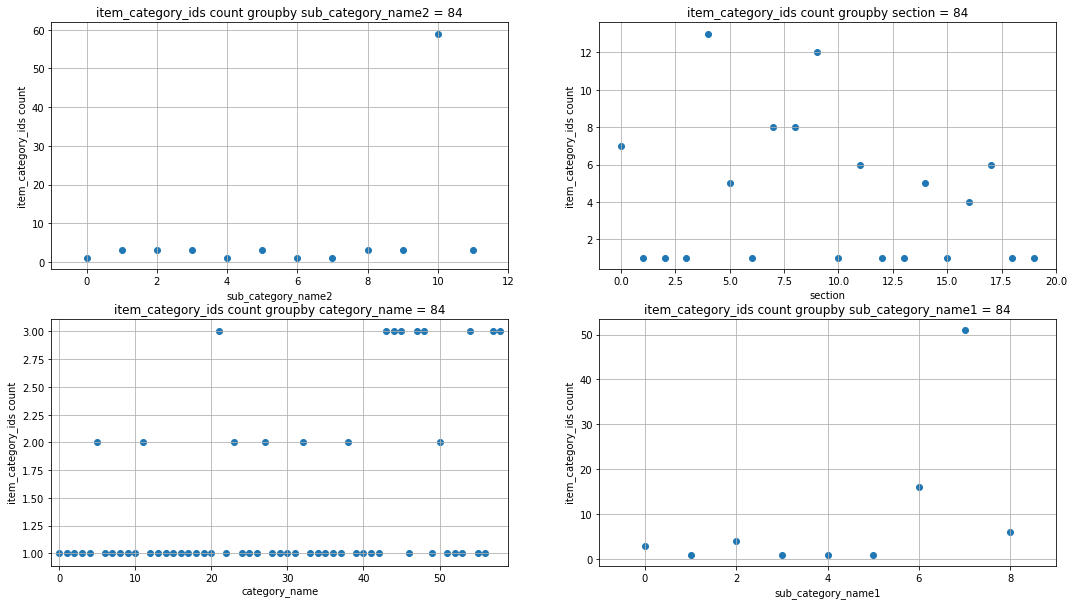

In [206]:
def extract_section_category_name(df):
    df['section'], df['category_name']  = df['item_category_name'].str.split('-', 1).str
    df['section'] = df['section'].str.strip()
    df['category_name'] = df['category_name'].str.strip()
    return df
def extract_subcategory_name1_subcategory_name2(row):
    if row['category_name'].startswith('ps'):
        row['sub_category_name1'] = 'ps'
        row['sub_category_name2'] = row.category_name.replace('ps', '')
    elif row['category_name'].startswith('xbox'):
        row['sub_category_name1'] = 'xbox'
        row['sub_category_name2'] = row.category_name.replace('xbox', '')
    elif row['category_name'].startswith('blu-ray'):
        row['sub_category_name1'] = 'blu-ray'
        row['sub_category_name2'] = row.category_name.replace('blu-ray', '')
    elif '(' in row['category_name']:
        row['category_name'], row['sub_category_name1']  = row['category_name'].split('(', 1)
    elif '(' in row['section']:
        row['section'], row['category_name']  = row['section'].split('(', 1)
    return row
def extract_info(df):
    df = extract_section_category_name(df)
    df = df.fillna('Unkown')
    df = df.apply(extract_subcategory_name1_subcategory_name2, axis = 1)
    df = df.fillna('Unkown')
    df = df[['item_category_id', 'item_category_name', 'section', 'category_name', 'sub_category_name1', 'sub_category_name2']]
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = df[col].str.strip().str.lower().str.replace('[()]+', '')
    return df

categories = extract_info(categories)
plot_target_counts_groupby_cols(categories, ['sub_category_name2', 'section', 'category_name', 'sub_category_name1'], 'item_category_id')

In [209]:
print('Number of item_category_id:', categories['item_category_id'].nunique())
print('Number of item_category_name:', categories['item_category_name'].nunique())
print('Number of category_name:', categories['category_name'].nunique())
print('Number of section:', categories['section'].nunique())
print('Number of sub_category_name1:', categories['sub_category_name1'].nunique())
print('Number of sub_category_name2:', categories['sub_category_name1'].nunique())

Number of item_category_id: 84
Number of item_category_name: 84
Number of category_name: 59
Number of section: 20
Number of sub_category_name1: 9
Number of sub_category_name2: 9


In [0]:
categories = categories.drop(columns = 'item_category_name', axis = 0)

**Possible Features**
- item_category_name
- section
- category_name
- sub_category_name1
- sub_category_name2


### Sales per category_id

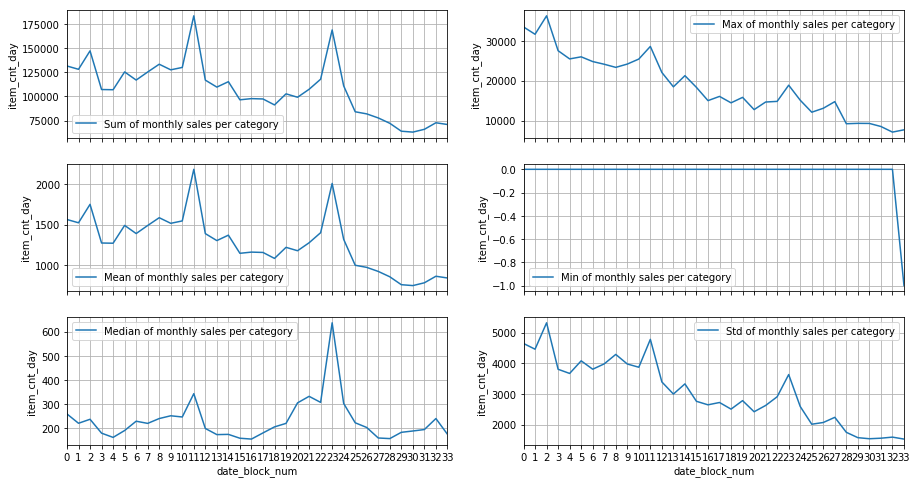

In [168]:
df = sales.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'inner')
sales_per_category = create_target_per_col(df, 'item_category_id', 'item_cnt_day', 'date_block_num')
plot_statistic(sales_per_category, 'monthly sales per category')

Maximum is decreasing. This means that new categories are created and some are not used and sold Items are associated partially with the old and the new categories.

In [169]:
for month in range(6, 34):
  cat_ids = sales_per_category['item_category_id'][sales_per_category.loc[:,'0':str(month)].sum(axis=1) == 0].unique()
  print('Until month: ', month, ', Categories that have made No sales are: ', cat_ids, len(cat_ids))

Until month:  6 , Categories that have made No sales are:  [ 7  8 12 16 17 20 24 26 27 32 34 36 39 42 47 50 51 53 74 80] 20
Until month:  7 , Categories that have made No sales are:  [ 7  8 12 16 17 20 24 26 27 34 36 39 42 47 50 51 53 74 80] 19
Until month:  8 , Categories that have made No sales are:  [ 7  8 12 16 17 20 24 26 27 34 36 42 47 50 51 53 74 80] 18
Until month:  9 , Categories that have made No sales are:  [ 7  8 12 16 17 20 24 26 27 34 36 42 47 50 51 74 80] 17
Until month:  10 , Categories that have made No sales are:  [ 7  8 16 17 24 26 27 34 36 42 47 50 51 74 80] 15
Until month:  11 , Categories that have made No sales are:  [ 7  8 16 24 26 27 34 36 42 47 50 51 74 80] 14
Until month:  12 , Categories that have made No sales are:  [ 7  8 16 24 26 27 34 36 42 47 50 51 74 80] 14
Until month:  13 , Categories that have made No sales are:  [ 7  8 16 24 26 27 34 36 42 47 50 51 74 80] 14
Until month:  14 , Categories that have made No sales are:  [ 7  8 16 24 26 27 34 36 42 47 

In [170]:
categories[categories['item_category_id'] == 36]

,item_category_id,section,category_name,sub_category_name1,sub_category_name2
36,36,payment cards,windows,digit,unkown


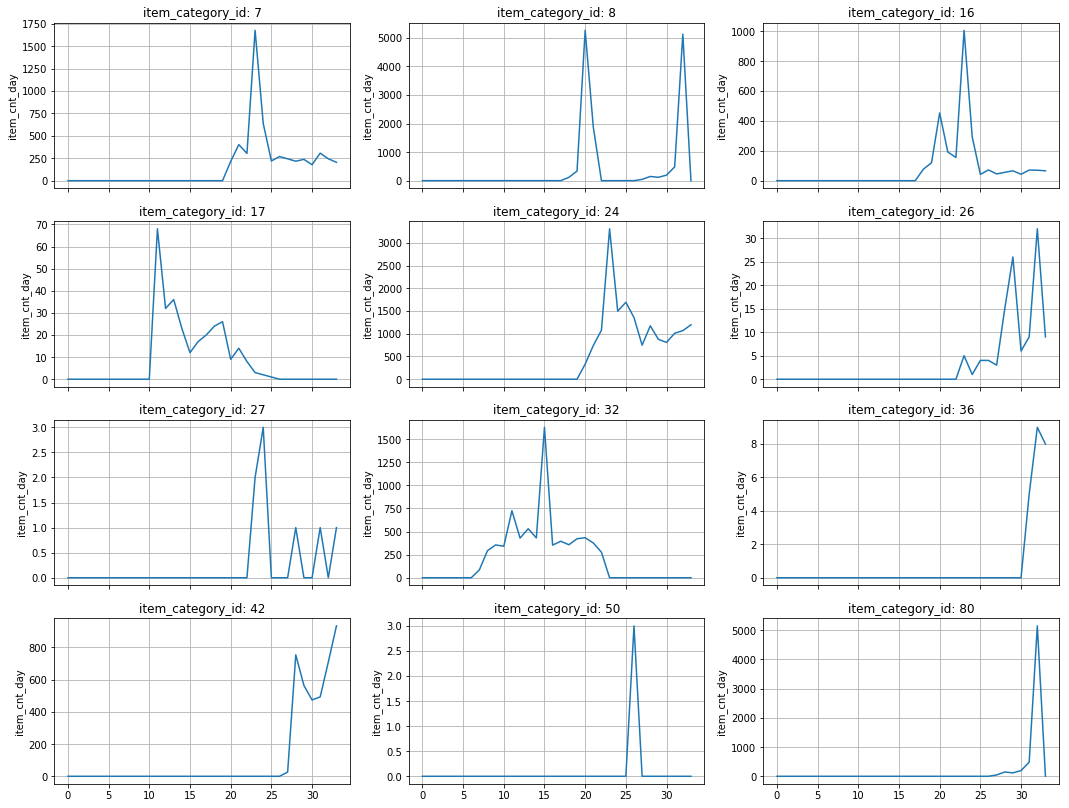

In [171]:
plot_target_per_col(sales_per_category, 'item_category_id', ids = [36, 42, 80, 50, 7, 8, 16, 17, 24, 26, 27, 32])

In [172]:
for month in range(6, 27):
    cat_ids = sales_per_category['item_category_id'][sales_per_category.loc[:, str(month):].sum(axis=1) == 0].unique()
    print('Since month: ', month, ', categories that stopped being sold: ', cat_ids, len(cat_ids))
outdated_categories = sales_per_category['item_category_id'][sales_per_category.loc[:, '26':].sum(axis=1) == 0].unique()

Since month:  6 , categories that stopped being sold:  [ 0  1 10 52] 4
Since month:  7 , categories that stopped being sold:  [ 0  1 10 52] 4
Since month:  8 , categories that stopped being sold:  [ 0  1 10 52] 4
Since month:  9 , categories that stopped being sold:  [ 0  1 10 52] 4
Since month:  10 , categories that stopped being sold:  [ 0  1 10 52] 4
Since month:  11 , categories that stopped being sold:  [ 0  1 10 48 52] 5
Since month:  12 , categories that stopped being sold:  [ 0  1 10 48 52] 5
Since month:  13 , categories that stopped being sold:  [ 0  1 10 48 52 68] 6
Since month:  14 , categories that stopped being sold:  [ 0  1 10 48 52 53 68] 7
Since month:  15 , categories that stopped being sold:  [ 0  1 10 48 52 53 68] 7
Since month:  16 , categories that stopped being sold:  [ 0  1 10 48 52 53 68] 7
Since month:  17 , categories that stopped being sold:  [ 0  1 10 48 52 53 68] 7
Since month:  18 , categories that stopped being sold:  [ 0  1 10 48 52 53 68] 7
Since month

item category with ids = [0,  1, 10, 52] are outdated

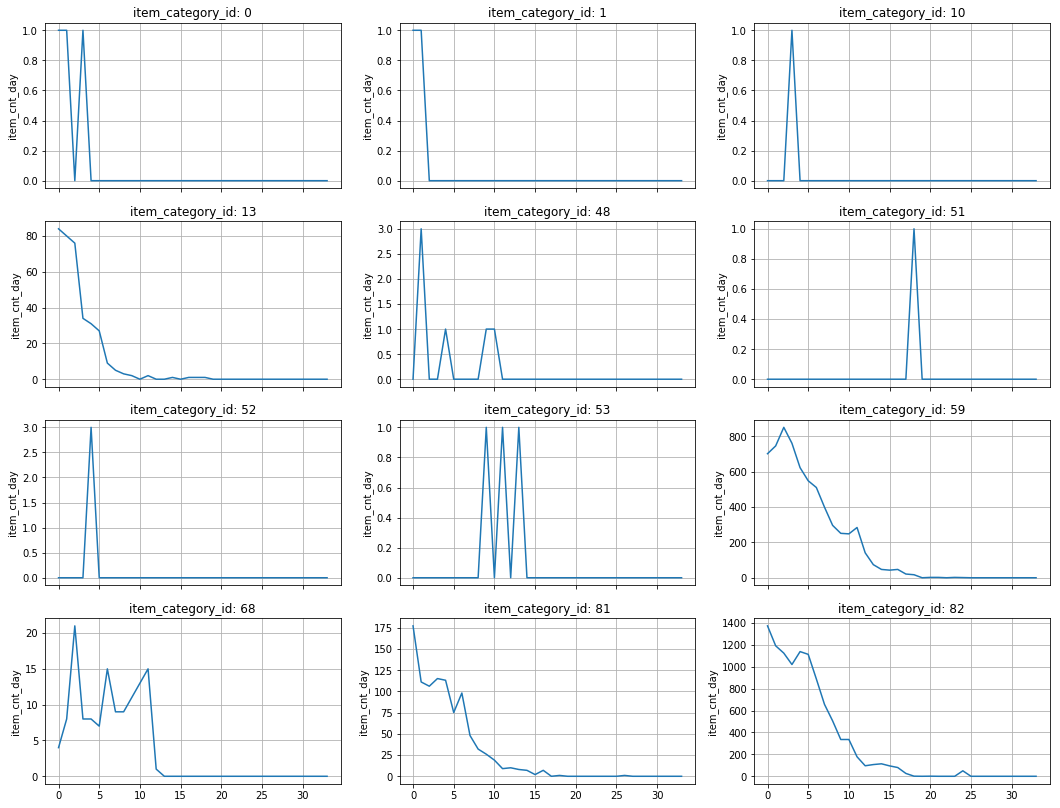

In [173]:
plot_target_per_col(sales_per_category, 'item_category_id', ids = [ 0,  1, 10, 13, 48, 51, 52, 53, 59, 68, 81, 82])

### Find categries in test set

In [174]:
test_item_ids = test_df['item_id'].unique()
test_categories = set(items[items['item_id'].isin(test_item_ids)]['item_category_id'])
train_categories = set(sales_per_category['item_category_id'])
outdated_categories = set(outdated_categories)
test_outdated_categories = test_categories.intersection(outdated_categories)
len(test_outdated_categories)

print('Categories number in train set: ', len(train_categories))
print('Outdated categories in train set: ', len(outdated_categories), outdated_categories)
print('Categories number in test set: ', len(test_categories))
print('Outdated categories in test set: ', len(test_outdated_categories), test_outdated_categories )

Categories number in train set:  84
Outdated categories in train set:  15 {0, 1, 32, 66, 68, 10, 13, 46, 48, 17, 82, 51, 52, 53, 59}
Categories number in test set:  62
Outdated categories in test set:  1 {0}


### Price per category

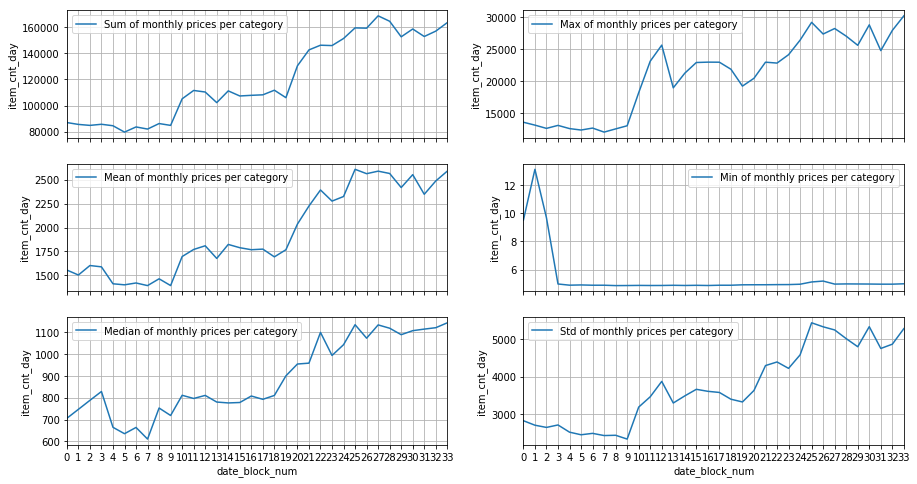

In [182]:
prices_per_category = create_target_per_col(df, 'item_category_id', 'item_price', 'date_block_num', aggfunc = np.mean, fill = np.nan)
plot_statistic(prices_per_category, 'monthly prices per category')

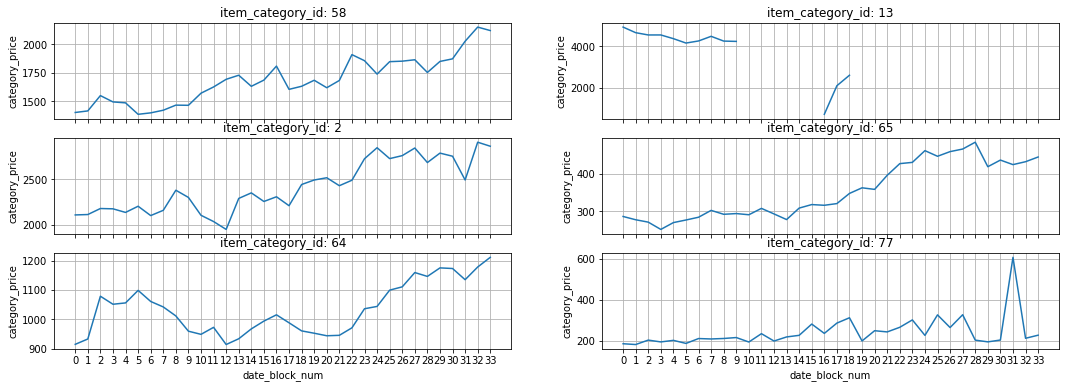

In [183]:
plot_target_per_col(prices_per_category, 'item_category_id', nrows = 3, ncols = 2, ids = [], xlbl = 'date_block_num', ylbl = 'category_price')

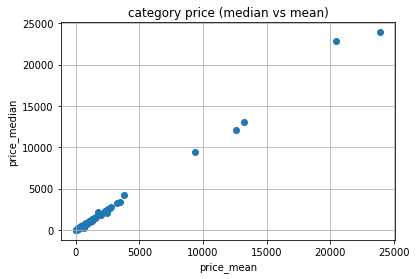

In [179]:
prices_per_category['price_mean'] = prices_per_category.loc[:, '0':].mean(axis = 1)
prices_per_category['price_median'] = prices_per_category.loc[:, '0':].median(axis = 1)
plt.scatter(prices_per_category.price_mean, prices_per_category.price_median)
plt.xlabel('price_mean')
plt.ylabel('price_median')
plt.title('category price (median vs mean)')
plt.show()

**Possible Features**
- Previous sales per category
- Price per category
- number of items belong to category
- is category outdated
- start/end month of sales for category

## Shops

In [184]:
shops.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
shop_name,60,60,"Москва ТЦ ""МЕГА Теплый Стан"" II",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_id,60,NaN,NaN,NaN,29.5,17.4642,0,14.75,29.5,44.25,59


### Display info

In [185]:
display_df_info(shops, 'Shops')
shops = downcast_dtypes(shops)

-----------Shape of Shops-------------
(60, 2)
-----------Missing values---------
shop_name    0
shop_id      0
dtype: int64
-----------Null values------------
shop_name    0
shop_id      0
dtype: int64
-----------Data types-------------
shop_name    object
shop_id       int64
dtype: object
-----------Memory usage (MB)------
0.01
Memory usage: 0.01 MB
New Memory usage: 0.01 MB


### Plot columns wrt each other

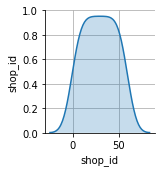

In [0]:
sns.pairplot(shops, diag_kind = 'kde')
plt.show()

### Shop name preprocessing
stolen form https://www.kaggle.com/kyakovlev

Shop name contains the following info:

- city | shop_type | c_shop_name

In [186]:
shops['c_shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['c_shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['c_shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'Unkown')
shops.head()

,shop_name,shop_id,c_shop_name,shop_city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,якутск орджоникидзе фран,якутск,Unkown
1,"!Якутск ТЦ ""Центральный"" фран",1,якутск тц центральный фран,якутск,тц
2,"Адыгея ТЦ ""Мега""",2,адыгея тц мега,адыгея,тц
3,"Балашиха ТРК ""Октябрь-Киномир""",3,балашиха трк октябрькиномир,балашиха,трк
4,"Волжский ТЦ ""Волга Молл""",4,волжский тц волга молл,волжский,тц


In [188]:
print('Shops number:', shops['shop_id'].nunique())
print('Shop names number:', shops['shop_name'].nunique())
print('Shop c_names number:', shops['c_shop_name'].nunique())
print('Shop cities number:', shops['shop_city'].nunique())
print('Shop types number:', shops['shop_city'].nunique())

Shops number: 60
Shop names number: 60
Shop c_names number: 60
Shop cities number: 31
Shop types number: 31


**Possible Features**
- shop_city
- shop_type

#### Find duplicated shops

In [10]:
similar_shops1 = find_similar_name(shops, 'c_shop_name', 15, 30)
similar_shops2 = find_similar_name(shops, 'c_shop_name', 7, 15)
similar_shops = similar_shops1 + similar_shops2
print_similar_pairs(shops, similar_shops, 'shop_id', 'c_shop_name')

40 :  ['ростовнадону трк мегацентр горизонт островной']
39 :  ['ростовнадону трк мегацентр горизонт']
---------------------
11 :  ['жуковский ул чкалова м²']
10 :  ['жуковский ул чкалова м']
---------------------
24 :  ['москва тк буденовский павк']
23 :  ['москва тк буденовский пава']
---------------------
31 :  ['москва тц семеновский']
30 :  ['москва тц перловский']
---------------------
57 :  ['якутск орджоникидзе']
0 :  ['якутск орджоникидзе  фран']
---------------------
58 :  ['якутск тц центральный']
1 :  ['якутск тц центральный фран']
---------------------
58 :  ['якутск тц центральный']
52 :  ['уфа тк центральный']
---------------------


**Drop the shops that do not exist in the Test set**

In [191]:
if (58, 52) in similar_shops: similar_shops.remove((58, 52))
if (31, 30) in similar_shops: similar_shops.remove((31, 30))
duplicated_shops_ids = list(sum(similar_shops, ()))
duplicated_shop_id_test = test_df[test_df['shop_id'].isin(duplicated_shops_ids)].shop_id.unique()
print('Duplicated shops Pairs in train set', similar_shops)
print('Shops that are found in test set from the pervious list: ', duplicated_shop_id_test)

Duplicated shops Pairs in train set [(40, 39), (11, 10), (24, 23), (57, 0), (58, 1)]
Shops that are found in test set from the pervious list:  [10 24 57 58 39]


In [0]:
sales.loc[sales['shop_id'] == 11, 'shop_id'] = 10
shops.loc[shops['shop_id'] == 11, 'shop_id'] = 10

sales.loc[sales['shop_id'] == 23, 'shop_id'] = 24
shops.loc[shops['shop_id'] == 23, 'shop_id'] = 24

sales.loc[sales['shop_id'] == 0, 'shop_id'] = 57
shops.loc[shops['shop_id'] == 0, 'shop_id'] = 57

sales.loc[sales['shop_id'] == 1, 'shop_id'] = 58
shops.loc[shops['shop_id'] == 1, 'shop_id'] = 58

sales.loc[sales['shop_id'] == 40, 'shop_id'] = 39
shops.loc[shops['shop_id'] == 40, 'shop_id'] = 39

shops = shops.drop_duplicates(subset = 'shop_id')

In [193]:
print('Shops number:', shops['shop_id'].nunique())
print('Shop cities number:', shops['shop_city'].nunique())
print('Shop types number:', shops['shop_type'].nunique())

Shops number: 55
Shop cities number: 31
Shop types number: 6


In [0]:
shops = shops.drop(columns = ['shop_name', 'c_shop_name'], axis = 0)

## Final data preparation

In [0]:
!fusermount -u drive


In [195]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/Colab Notebooks/predict_future_sales/data/prep/'

Mounted at /content/drive/


In [196]:
print(sales.shape)
print(shops.shape)
print(categories.shape)
print(items.shape, nitems.shape)
test_df = pd.read_csv('test.csv.gz').set_index('ID')
print(test_df.shape)


(2935842, 6)
(55, 3)
(84, 5)
(22170, 3) (22170, 6)
(214200, 2)


In [0]:
sales.to_pickle(data_path + 'sales.pkl')

In [0]:
nitems.to_pickle(data_path + 'items.pkl')

In [0]:
categories.to_pickle(data_path + 'item_categories.pkl')

In [0]:
shops.to_pickle(data_path + 'shops.pkl')

In [0]:
test_df.to_pickle(data_path + 'test.pkl')